### Plotting Benchmarks

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

METRICS_PATH = '/usr/local/google/home/tanjihui/Desktop/ipra-dev/metrics'
df = pd.read_csv(f'{METRICS_PATH}/performance_metrics.csv')
# Filter to get only the rows with individual runs (1, 2, 3, etc.)
df_runs = df[pd.to_numeric(df['Run'], errors='coerce').notnull()].copy()
df_runs['Run'] = df_runs['Run'].astype(int)

# ==============================================================================
# CORRECTIVE STEP: As you instructed, we create the 'TotalCPUTime_s' column
# by combining 'UserTime_s' and 'SysTime_s'. This is now done directly on the
# 'df_runs' DataFrame to ensure it exists for all subsequent operations.
df_runs['TotalCPUTime_s'] = df_runs['UserTime_s'] + df_runs['SysTime_s']
# ==============================================================================

# Create the "warm runs" DataFrame (excluding run 1) from the corrected df_runs
warm_runs_df = df_runs[df_runs['Run'] > 1].copy()

# Set a consistent plot style for all graphs
plt.style.use('seaborn-v0_8-whitegrid')


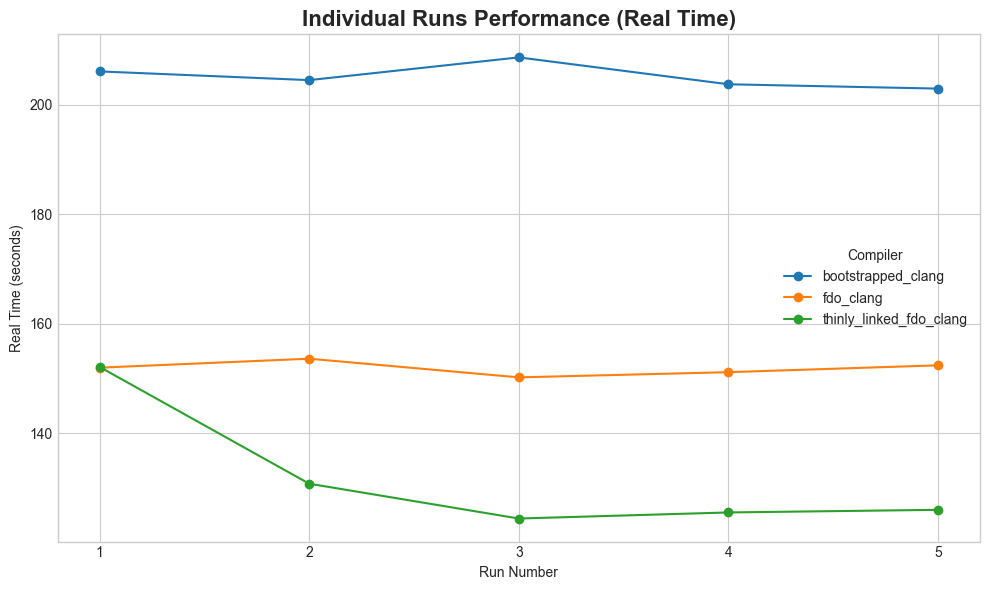

In [4]:
# --- 2. Generate Plots for Real Time ---

# 2a. Individual Runs - Real Time
pivot_real = df_runs.pivot(index='Run', columns='Compiler', values='RealTime_s')
fig, ax = plt.subplots(figsize=(10, 6))
pivot_real.plot(kind='line', marker='o', ax=ax)
ax.set_title('Individual Runs Performance (Real Time)', fontsize=16, fontweight='bold')
ax.set_ylabel('Real Time (seconds)')
ax.set_xlabel('Run Number')
ax.legend(title='Compiler')
ax.set_xticks(df_runs['Run'].unique())
plt.tight_layout()
plt.show()

/tmp/ipykernel_2255216/919862672.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(avg_real.index, rotation=0)


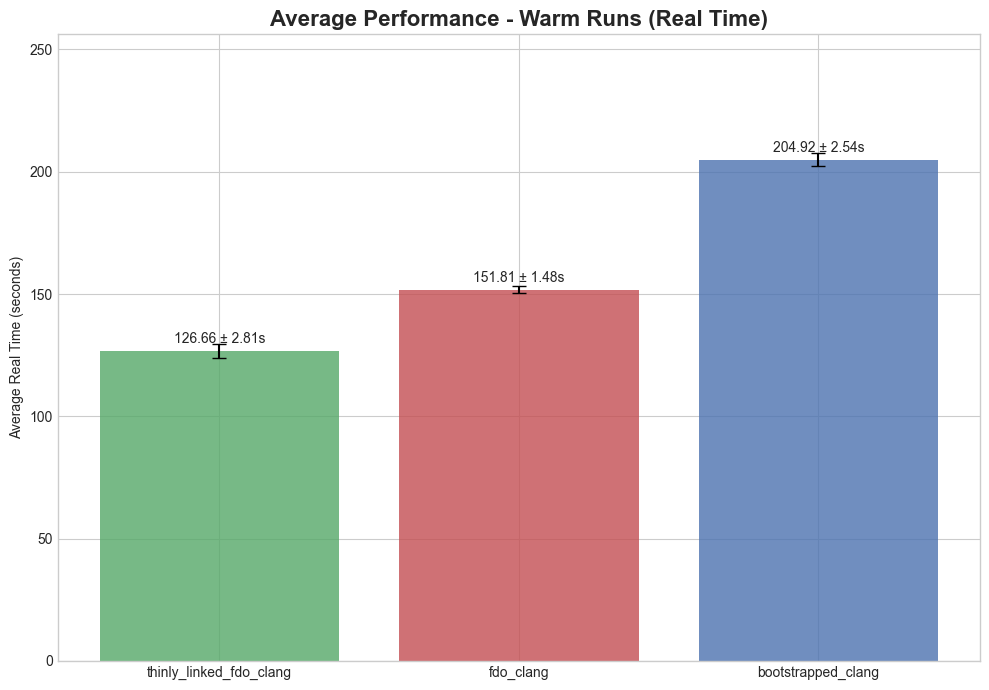

In [5]:
# 2b. Average Performance (Warm Runs) - Real Time
avg_real = warm_runs_df.groupby('Compiler')['RealTime_s'].mean().sort_values()
std_real = warm_runs_df.groupby('Compiler')['RealTime_s'].std().reindex(avg_real.index)
fig, ax = plt.subplots(figsize=(10, 7))
bars = ax.bar(avg_real.index, avg_real, yerr=std_real, capsize=5,
              color=['#55a868', '#c44e52', '#4c72b0'], alpha=0.8)
ax.set_title('Average Performance - Warm Runs (Real Time)', fontsize=16, fontweight='bold')
ax.set_ylabel('Average Real Time (seconds)')
ax.set_xticklabels(avg_real.index, rotation=0)
ax.set_ylim(0, avg_real.max() * 1.25)
for i, bar in enumerate(bars):
    yval = bar.get_height()
    avg_val = avg_real.iloc[i]
    std_val = std_real.iloc[i]
    label = f'{avg_val:.2f} ± {std_val:.2f}s'
    ax.text(bar.get_x() + bar.get_width()/2.0, yval + 2, label, ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.show()

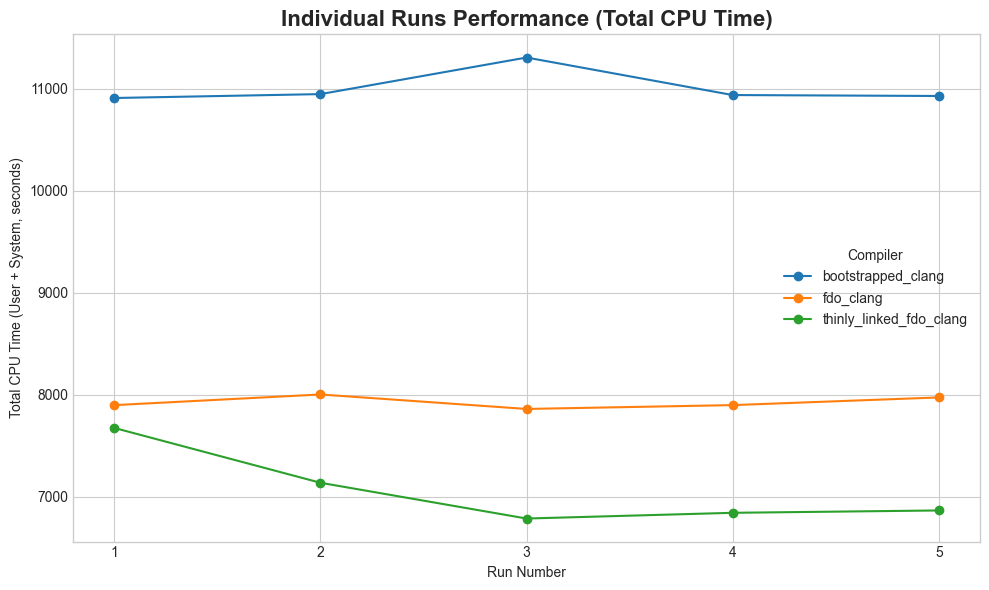

In [6]:
# --- 3. Generate Plots for Total CPU Time ---
# 3a. Individual Runs - Total CPU Time
pivot_cpu = df_runs.pivot(index='Run', columns='Compiler', values='TotalCPUTime_s')
fig, ax = plt.subplots(figsize=(10, 6))
pivot_cpu.plot(kind='line', marker='o', ax=ax)
ax.set_title('Individual Runs Performance (Total CPU Time)', fontsize=16, fontweight='bold')
ax.set_ylabel('Total CPU Time (User + System, seconds)')
ax.set_xlabel('Run Number')
ax.legend(title='Compiler')
ax.set_xticks(df_runs['Run'].unique())
plt.tight_layout()
plt.show()


/tmp/ipykernel_2255216/3212994367.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(avg_cpu.index, rotation=0)


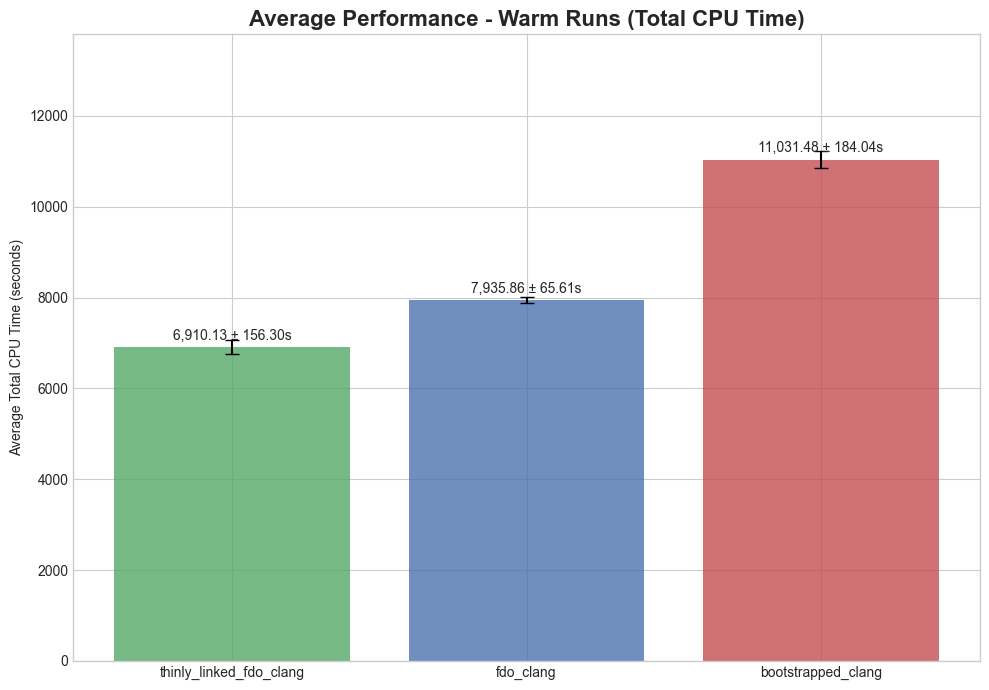

In [9]:
# 3b. Average Performance (Warm Runs) - Total CPU Time
avg_cpu = warm_runs_df.groupby('Compiler')['TotalCPUTime_s'].mean().sort_values()
std_cpu = warm_runs_df.groupby('Compiler')['TotalCPUTime_s'].std().reindex(avg_cpu.index)
fig, ax = plt.subplots(figsize=(10, 7))
bars = ax.bar(avg_cpu.index, avg_cpu, yerr=std_cpu, capsize=5,
              color=['#55a868', '#4c72b0', '#c44e52'], alpha=0.8)
ax.set_title('Average Performance - Warm Runs (Total CPU Time)', fontsize=16, fontweight='bold')
ax.set_ylabel('Average Total CPU Time (seconds)')
ax.set_xticklabels(avg_cpu.index, rotation=0)
ax.set_ylim(0, avg_cpu.max() * 1.25)
for i, bar in enumerate(bars):
    yval = bar.get_height()
    avg_val = avg_cpu.iloc[i]
    std_val = std_cpu.iloc[i]
    label = f'{avg_val:,.2f} ± {std_val:.2f}s'
    ax.text(bar.get_x() + bar.get_width()/2.0, yval + 100, label, ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.show()